# Homework: SMS Spam Classification

**Course:** Deep Learning

**Objective:** Train a model to classify SMS messages as spam or ham.

**Dataset:** SMS Spam Collection  
* **Source:** UCI ML Repository  
* **Download:** https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection  
* **Size:** ~5 500 messages (13 % spam, 87 % ham)  
* **Format:** TSV with columns  
  * `label`: “spam” (1) / “ham” (0)
  * `text`: raw SMS content  

**Tasks:**
1. Load and explore the dataset.
2. Preprocess the text.
3. Define and train a model (any method from the course).
4. Evaluate the model's performance using standard classification metrics on the test set.

> **Success:** achieve ≥ 0.90 F1-score on the test set.  


# Prerequisites
There might be pip errors, just ignore them, it's okay...

In [1]:
!nvidia-smi

Tue May 13 10:46:09 2025       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100S-PCI...  On   | 00000000:3B:00.0 Off |                    0 |
| N/A   29C    P0    25W / 250W |      0MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100S-PCI...  On   | 00000000:86:00.0 Off |                    0 |
| N/A   

In [1]:
import os
import random
import numpy as np
import torch
import requests, zipfile, io
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, roc_auc_score 
from transformers import BertTokenizerFast, BertTokenizer, BertModel, AutoModel, BertForSequenceClassification, Trainer, TrainingArguments, set_seed
from datasets import Dataset

# Dont change ssid for accurate testing results
ssid = 42
random.seed(ssid)
np.random.seed(ssid)
torch.manual_seed(ssid)
torch.cuda.manual_seed_all(ssid)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True
set_seed(ssid)

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print(f'Using device: {device}')

def download_data():
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip"
    response = requests.get(url)
    with zipfile.ZipFile(io.BytesIO(response.content)) as z:
        z.extractall("data")
    df = pd.read_csv("data/SMSSpamCollection", sep='\t', header=None, names=['label', 'text'])
    df['label'] = df['label'].map({'ham': 0, 'spam': 1})
    return df

def train_val_test(df):
    train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=ssid)
    val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=ssid)
    return train_df, val_df, test_df

/home/amorozov/.conda/envs/bert/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


# Data

In [2]:
df = download_data()
print(df.head(10))

   label                                               text
0      0  Go until jurong point, crazy.. Available only ...
1      0                      Ok lar... Joking wif u oni...
2      1  Free entry in 2 a wkly comp to win FA Cup fina...
3      0  U dun say so early hor... U c already then say...
4      0  Nah I don't think he goes to usf, he lives aro...
5      1  FreeMsg Hey there darling it's been 3 week's n...
6      0  Even my brother is not like to speak with me. ...
7      0  As per your request 'Melle Melle (Oru Minnamin...
8      1  WINNER!! As a valued network customer you have...
9      1  Had your mobile 11 months or more? U R entitle...


# Data preprocessing

In [3]:
from tqdm.auto import tqdm
from plotly.subplots import make_subplots
from plotly.offline import iplot
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.figure_factory as ff
import plotly.express as px
%matplotlib inline
sns.set_style("darkgrid")
large = 14; med = 10; small = 6
params = {'axes.titlesize': med,
          'legend.fontsize': small,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': small,
          'ytick.labelsize': small,
          'figure.titlesize': large,
          'axes.grid': True,
          'grid.alpha': 0.8,}
plt.rcParams.update(params)

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset, RandomSampler, SequentialSampler
from torch.optim.lr_scheduler import OneCycleLR, CosineAnnealingWarmRestarts, ReduceLROnPlateau
from torch.nn.utils import clip_grad_norm_

import re
from bs4 import BeautifulSoup
import lxml

In [4]:
def text_cleaning(text):
    '''
    Cleans text into a basic form:
    1. Remove numbers and special charecters (&, #, etc.)
    2. Remove extra spaces
    3. Remove RT in case of Re-Tweets
    5. Remove embedded URL links
    6. Remove HTML tags
    7. Remove emojis
    8. Make all text lowercase
    
    text - Text piece to be cleaned.
    '''
    template = re.compile(r'https?://\S+|www\.\S+') #Removes website links
    text = template.sub(r'', text)
    
    soup = BeautifulSoup(text, 'lxml') #Removes HTML tags
    only_text = soup.get_text()
    text = only_text
    
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    
    text = str(text).lower()
    text = re.sub(r"[^a-zA-Z\d\s]", " ", text) #Remove special Charecters
    text = re.sub(' +', ' ', text) #Remove Extra Spaces
    text = re.sub(r"RT ", " ", text) #Remove RT for Re-tweets
    text = re.sub(r"[0-9]", " ", text) #Remove Numbers
    text = text.strip() # remove spaces at the beginning and at the end of string

    return text


def simple_text_cleaning(text):
    text = str(text).lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove URLs
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

In [5]:
tqdm.pandas(desc="Preprocessing text")
df['text'] = df['text'].progress_apply(simple_text_cleaning)

Preprocessing text: 100%|██████████| 5572/5572 [00:00<00:00, 103701.38it/s]


In [6]:
train_df, val_df, test_df = train_val_test(df)

(5572, 2)


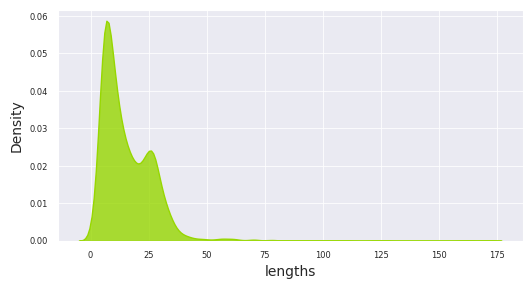

In [7]:
print(df.shape)
df_plot = df.copy()
df_plot['lengths'] = [len(x.split()) for x in df_plot.text.values]

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
sns.kdeplot(data=df_plot, x='lengths', fill=True, color='#97d700', alpha=.8, ax=ax)
plt.show()

In [8]:
class_weights = compute_class_weight(
    class_weight='balanced', 
    classes=np.unique(train_df.label.values), 
    y=train_df.label.values
)
print(class_weights)
weights = torch.tensor(class_weights, dtype=torch.float)

[0.57743559 3.72848948]


# Your training code here

In [25]:
params = {
    'checkpoint': 'bert-base-uncased',
    'class_weights': weights,
    'output_logits': 768,
    'max_len': 25,
    'batch_size': 64,
    'dropout': 0.1,
    'num_workers': 2,
    'epochs': 10,
    'lr': 2e-5,
    'scheduler_name': 'ReduceLROnPlateau',
    'max_lr': 5e-3,                 # OneCycleLR
    'pct_start': 0.3,               # OneCycleLR
    'anneal_strategy': 'cos',       # OneCycleLR
    'div_factor': 1e3,              # OneCycleLR
    'final_div_factor': 1e3,        # OneCycleLR
    'T_0': 3,                      # CosineAnnealingWarmRestarts
    'min_lr': 1e-5,                 # CosineAnnealingWarmRestarts   
    }

In [26]:
class BERTDataset:
    def __init__(self, texts, labels, max_len=params['max_len'], checkpoint=params['checkpoint']):
        self.texts = texts
        self.labels = labels
        self.max_len = max_len
        self.tokenizer = BertTokenizerFast.from_pretrained(checkpoint)
        self.num_examples = len(self.texts)

    def __len__(self):
        return self.num_examples

    def tokenize(self):
        
        tokens = self.tokenizer.batch_encode_plus(
            self.texts.tolist(),
            max_length = self.max_len,
            pad_to_max_length=True,
            truncation=True,
            return_token_type_ids=False
            )
        
        ids = torch.tensor(tokens['input_ids'], dtype=torch.long)
        mask = torch.tensor(tokens['attention_mask'], dtype=torch.long)
        labels = torch.tensor(self.labels.tolist(), dtype=torch.long)

        return TensorDataset(ids, mask, labels)

In [27]:
def get_scheduler(optimizer, scheduler_params=params):
    if scheduler_params['scheduler_name'] == 'CosineAnnealingWarmRestarts':
        scheduler = CosineAnnealingWarmRestarts(
            optimizer,
            T_0=scheduler_params['T_0'],
            eta_min=scheduler_params['min_lr'],
            last_epoch=-1
            )
    elif scheduler_params['scheduler_name'] == 'OneCycleLR':
        scheduler = OneCycleLR(
            optimizer,
            max_lr=scheduler_params['max_lr'],
            steps_per_epoch=int(train_df.shape[0] / params['batch_size']) + 1,
            epochs=scheduler_params['epochs'],
            pct_start=scheduler_params['pct_start'],
            anneal_strategy=scheduler_params['anneal_strategy'],
            div_factor=scheduler_params['div_factor'],
            final_div_factor=scheduler_params['final_div_factor'],
            )
    elif scheduler_params['scheduler_name'] == 'ReduceLROnPlateau':
        scheduler = ReduceLROnPlateau(
            optimizer, 
            mode='min', 
            factor=0.1, 
            patience=10, 
            threshold=0.0001, 
            threshold_mode='rel', 
            cooldown=0, 
            min_lr=0, 
            eps=1e-08
            )
    return scheduler

In [28]:
class SpamDetector(nn.Module):
    def __init__(self, checkpoint=params['checkpoint'], params=params):
        super(SpamDetector, self).__init__()
        self.bert = AutoModel.from_pretrained(checkpoint, return_dict=False)
        self.dropout = nn.Dropout(params['dropout'])
        self.fc1 = nn.Linear(768, 512)
        self.fc2 = nn.Linear(512, 2)
        self.relu = nn.ReLU()
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(input_ids, attention_mask)
        pooled_output = self.fc1(pooled_output)
        pooled_output = self.relu(pooled_output)
        pooled_output = self.dropout(pooled_output)
        logits = self.fc2(pooled_output)
        # output = self.softmax(logits)
        return logits

In [29]:
def usr_f1_score(output, target):
    y_pred = torch.argmax(output, dim=1).cpu().numpy()
    target = target.cpu()
    return f1_score(target, y_pred, average='binary') 

def usr_roc_score(output, target):
    try:
        probs = torch.softmax(output, dim=1)[:, 1].cpu().detach().numpy()
        target = target.cpu().numpy()
        return roc_auc_score(target, probs)
    except:
        return 0.5

In [30]:
def train(model, device, train_dataset, valid_dataset, params=params, epochs=params['epochs'], scheduler=params['scheduler_name']):
    model.to(device)
    weights = params['class_weights'].to(device)
    optimizer = optim.AdamW(model.parameters(), lr=params['lr'])
    clip_grad_norm_(model.parameters(), max_norm=1.0)
  
    if scheduler is not None:
        scheduler = get_scheduler(optimizer)
  
    criterion = nn.CrossEntropyLoss(weight=weights)
    best_valid_loss = float('inf')

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_f1 = 0
        train_roc = 0
        stream_1 = tqdm(train_dataset)
        stream_1.set_description('Training')
        for batch in stream_1:
            optimizer.zero_grad()
            batch = [r.to(device) for r in batch]
            ids, mask, target = batch
            logits = model(ids, mask)
            loss = criterion(logits, target)
            f1_score = usr_f1_score(logits, target)
            roc_score = usr_roc_score(logits, target)
            loss.backward()
            optimizer.step()
            if scheduler and params['scheduler_name'] != 'ReduceLROnPlateau':  # Step here only for non-plateau
                scheduler.step()
            train_loss += loss.item() * ids.size(0)
            train_f1 += f1_score
            train_roc += roc_score
            stream_1.update(1)
    
        train_loss/= len(train_dataset)
        train_f1 /= len(train_dataset)
        train_roc /= len(train_dataset)

        model.eval()
        valid_loss = 0
        valid_f1 = 0
        valid_roc = 0
        stream_2 = tqdm(valid_dataset)
        stream_2.set_description('Validating')
        for batch in stream_2:
            batch = [r.to(device) for r in batch]
            ids, mask, target = batch
            logits = model(ids, mask)
            loss = criterion(logits, target)
            f1_score = usr_f1_score(logits, target)
            roc_score = usr_roc_score(logits, target)
            valid_loss += loss.item() * ids.size(0)
            valid_f1 += f1_score
            valid_roc += roc_score
            stream_2.update(1)

        valid_loss /= len(valid_dataset)
        valid_f1 /= len(valid_dataset)
        valid_roc /= len(valid_dataset)
        
        # Step ReduceLROnPlateau after validation
        if scheduler and params['scheduler_name'] == 'ReduceLROnPlateau':
            scheduler.step(valid_loss)
        
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), 'saved_weights.pt')

        print(f"Epoch: {epoch+1:02}/{epochs:02}. Train Loss: {train_loss:.3f}. Validation Loss: {valid_loss:.3f}")
        print(f"Epoch: {epoch+1:02}/{epochs:02}. Train F1: {train_f1:.3f}. Validation F1: {valid_f1:.3f}")
        print(f"Epoch: {epoch+1:02}/{epochs:02}. Train ROC: {train_roc:.3f}. Validation ROC: {valid_roc:.3f}")

In [31]:
train_dataset = BERTDataset(
    train_df.text.values,
    train_df.label.values
).tokenize()

val_dataset = BERTDataset(
    val_df.text.values,
    val_df.label.values
).tokenize()

train_dataloader = DataLoader(
    train_dataset, 
    batch_size=params['batch_size'], 
    sampler=RandomSampler(train_dataset), 
    #shuffle=True,
    num_workers=params['num_workers'], 
    pin_memory=True
)

val_dataloader = DataLoader(
    val_dataset, 
    batch_size=params['batch_size'], 
    sampler=SequentialSampler(val_dataset), 
    #shuffle=False,
    num_workers=params['num_workers'], 
    pin_memory=True
)

/home/amorozov/.conda/envs/bert/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2700: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).



In [32]:
model = SpamDetector()
train(model, device, train_dataloader, val_dataloader)

  0%|          | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training:   0%|          | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the e

Epoch: 01/10. Train Loss: 21.255. Validation Loss: 8.062
Epoch: 01/10. Train F1: 0.779. Validation F1: 0.914
Epoch: 01/10. Train ROC: nan. Validation ROC: 0.980


  0%|          | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training:   0%|          | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fo

Epoch: 02/10. Train Loss: 5.371. Validation Loss: 5.794
Epoch: 02/10. Train F1: 0.938. Validation F1: 0.917
Epoch: 02/10. Train ROC: 0.994. Validation ROC: 0.997


  0%|          | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training:   0%|          | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the e

Epoch: 03/10. Train Loss: 2.775. Validation Loss: 9.441
Epoch: 03/10. Train F1: 0.970. Validation F1: 0.940
Epoch: 03/10. Train ROC: 0.999. Validation ROC: 0.975


  0%|          | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training:   0%|          | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the e

Epoch: 04/10. Train Loss: 0.797. Validation Loss: 8.369
Epoch: 04/10. Train F1: 0.993. Validation F1: 0.940
Epoch: 04/10. Train ROC: 1.000. Validation ROC: 0.984


  0%|          | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training:   0%|          | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the e

Epoch: 05/10. Train Loss: 1.485. Validation Loss: 9.344
Epoch: 05/10. Train F1: 0.971. Validation F1: 0.938
Epoch: 05/10. Train ROC: 1.000. Validation ROC: 0.974


  0%|          | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training:   0%|          | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fo

Epoch: 06/10. Train Loss: 0.387. Validation Loss: 9.147
Epoch: 06/10. Train F1: 0.995. Validation F1: 0.945
Epoch: 06/10. Train ROC: 1.000. Validation ROC: 0.981


  0%|          | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training:   0%|          | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the e

Epoch: 07/10. Train Loss: 0.140. Validation Loss: 11.512
Epoch: 07/10. Train F1: 0.999. Validation F1: 0.949
Epoch: 07/10. Train ROC: 1.000. Validation ROC: 0.982


  0%|          | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training:   0%|          | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the e

Epoch: 08/10. Train Loss: 0.078. Validation Loss: 11.917
Epoch: 08/10. Train F1: 1.000. Validation F1: 0.949
Epoch: 08/10. Train ROC: 1.000. Validation ROC: 0.984


  0%|          | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training:   0%|          | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the e

Epoch: 09/10. Train Loss: 0.648. Validation Loss: 10.617
Epoch: 09/10. Train F1: 0.989. Validation F1: 0.952
Epoch: 09/10. Train ROC: 1.000. Validation ROC: 0.985


  0%|          | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training:   0%|          | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the e

Epoch: 10/10. Train Loss: 0.455. Validation Loss: 7.803
Epoch: 10/10. Train F1: 0.989. Validation F1: 0.961
Epoch: 10/10. Train ROC: 1.000. Validation ROC: 0.984


# Evaluation

In [34]:
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))
tokenizer = BertTokenizerFast.from_pretrained(params['checkpoint'])

tokens_test = tokenizer.batch_encode_plus(
    test_df.text.tolist(),
    max_length = params['max_len'],
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)
test_ids = torch.tensor(tokens_test['input_ids'], dtype=torch.long)
test_mask = torch.tensor(tokens_test['attention_mask'], dtype=torch.long)
test_labels = torch.tensor(test_df.label.to_list(), dtype=torch.float)

# Get raw logits from model
logits = model(test_ids.to(device), test_mask.to(device))

y_pred_probs = torch.softmax(logits, dim=1).cpu().detach().numpy()
y_pred_test = np.argmax(y_pred_probs, axis=1)

test_labels_np = test_labels.cpu().numpy().astype(int)

acc, prec, rec, f1 = accuracy_score(test_labels_np, y_pred_test), *precision_recall_fscore_support(test_labels_np, y_pred_test, average='binary')[:3]
print("\nTest —     acc: {:.3f}, prec: {:.3f}, rec: {:.3f}, f1: {:.3f}".format(
    acc, prec, rec, f1
))

/home/amorozov/.conda/envs/bert/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2700: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).




Test —     acc: 0.974, prec: 0.846, rec: 0.982, f1: 0.909
